In [89]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage
import torch
import torch.nn.functional as func

In [90]:
# folder = "D2"
folder = "D3"

# name = "T_S04856"
# name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
name = "T_S04923"

# name = "T_S03705"

png_file = Path(f"../../data/seathru/{folder}/{folder}/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/{folder}/{folder}/depth/depth{name}.tif")

In [91]:
clusters = 10

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [93]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [94]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

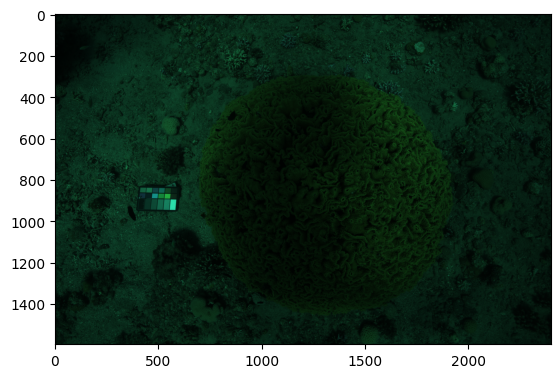

In [95]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [96]:
png.dtype

dtype('float64')

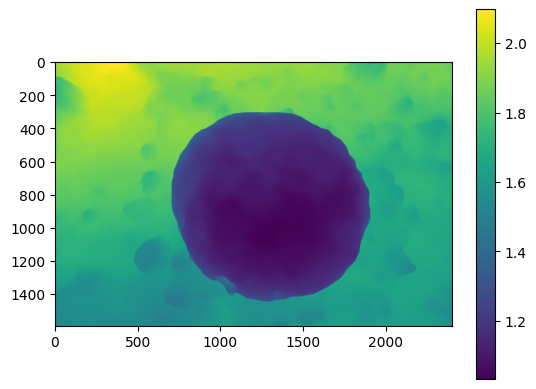

In [97]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [98]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [99]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [100]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

In [101]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

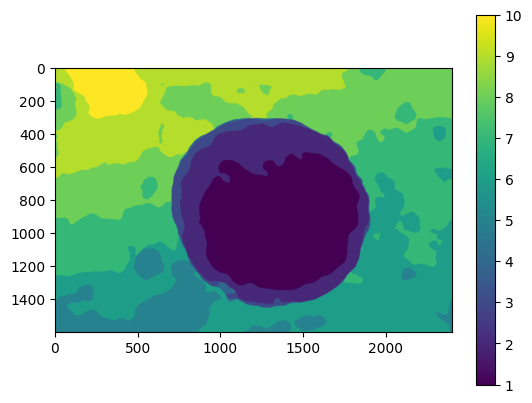

In [102]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [103]:
np.unique_counts(labels)

UniqueCountsResult(values=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8), counts=array([624129, 367726,  80555,  11589, 263087, 699030, 563987, 637811,
       473182, 109304]))

In [104]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [105]:
idx

(array([    5,     6,     7, ..., 84615, 84616, 84957], shape=(1167,)),)

In [106]:
len(idx) / pixels.shape[0]

9.148796018443973e-06

In [107]:
pixels <= np.percentile(pixels, 1, axis=0), pixels[0],  np.percentile(pixels, 1, axis=0)

(array([[False, False,  True],
        [False, False,  True],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]], shape=(109304, 3)),
 array([0.02352941, 0.03137255, 0.00392157]),
 array([0.01960784, 0.02745098, 0.00392157]))

In [108]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [109]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.01442094820384294, (55238,))

In [110]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [111]:
z_values

array([1.1349144 , 1.13483131, 1.13463235, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(55238,))

In [112]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [113]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z) - B_hat

In [114]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=1):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), loss='soft_l1', bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [115]:
# dsssdfsd

In [116]:
dark_pixels

array([[0.00392157, 0.01176471, 0.        ],
       [0.00392157, 0.01176471, 0.        ],
       [0.00392157, 0.01176471, 0.        ],
       ...,
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157]], shape=(55238, 3))

In [117]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.92937286 0.81600949 0.6175472  1.93843681]
0.7584245149400999 [1.00000000e+00 7.30695761e-03 4.08620136e-34 4.99124824e+00]


(array([1.00000000e+00, 7.30695761e-03, 4.08620136e-34, 4.99124824e+00]),
 np.float64(0.7584245149400999))

In [118]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.96364599 2.72788852 0.64923525 2.07599957]
0.8817816163014249 [1.00000000e+00 1.19615790e-02 1.73324918e-26 4.98248241e+00]


(array([1.00000000e+00, 1.19615790e-02, 1.73324918e-26, 4.98248241e+00]),
 np.float64(0.8817816163014249))

In [119]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.48767356 0.90755739 0.42905235 1.36414538]


0.37897087093135096 [9.99999988e-01 1.62139611e-03 2.57548087e-83 4.99881165e+00]


(array([9.99999988e-01, 1.62139611e-03, 2.57548087e-83, 4.99881165e+00]),
 np.float64(0.37897087093135096))

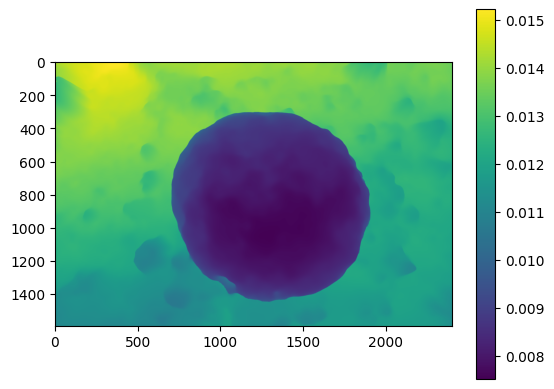

In [120]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

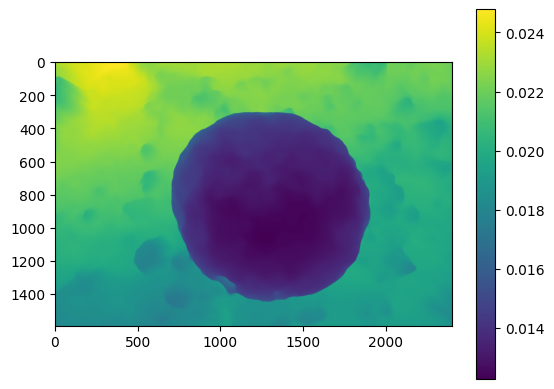

In [121]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

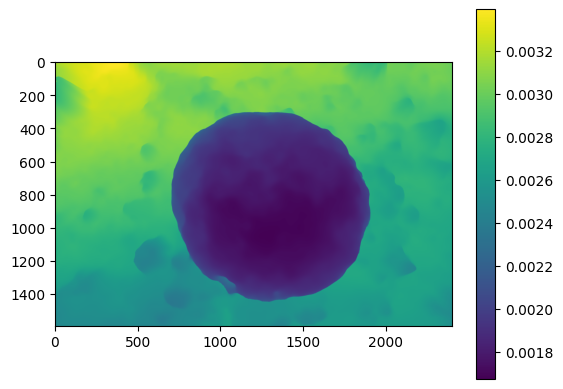

In [122]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

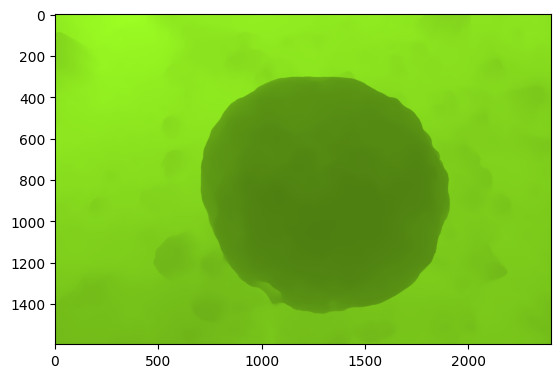

In [123]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

In [124]:
png

array([[[0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04313725, 0.00784314],
        ...,
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784]],

       [[0.02352941, 0.03921569, 0.00784314],
        [0.02352941, 0.03529412, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784]],

       [[0.02352941, 0.03529412, 0.00392157],
        [0.01960784, 0.03137255, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784]],

       ...,

       [[0.04705882, 0.0745098 , 0.01176471],
        [0.04313725, 0.0745098 , 0.01568627],
        [0.03137255, 0

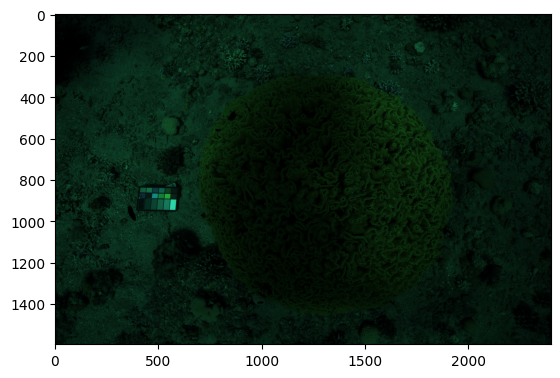

In [125]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

direct_signal = np.clip(direct_signal, 0, 1)

imshow(direct_signal, color_channel="bgr")

In [126]:
direct_signal

array([[[0.01327016, 0.02394967, 0.00467894],
        [0.01327016, 0.02394967, 0.00467894],
        [0.01326455, 0.02001901, 0.00467768],
        ...,
        [0.04535701, 0.0721675 , 0.01660387],
        [0.04535899, 0.07217072, 0.01660432],
        [0.04536443, 0.07217954, 0.01660554]],

       [[0.00934859, 0.01610654, 0.00467894],
        [0.00934859, 0.01218497, 0.00075737],
        [0.00934298, 0.01217587, 0.00075611],
        ...,
        [0.04535701, 0.07608907, 0.01660387],
        [0.04535899, 0.07609229, 0.01660432],
        [0.04536443, 0.07610111, 0.01660554]],

       [[0.00935125, 0.01218929, 0.00075797],
        [0.00542968, 0.00826772, 0.00075797],
        [0.0093458 , 0.01218044, 0.00075674],
        ...,
        [0.04143537, 0.07216739, 0.01660386],
        [0.0414402 , 0.07217523, 0.01660494],
        [0.04144312, 0.07217996, 0.0166056 ]],

       ...,

       [[0.03596799, 0.05641819, 0.00929299],
        [0.03204642, 0.05641819, 0.01321456],
        [0.02028066, 0

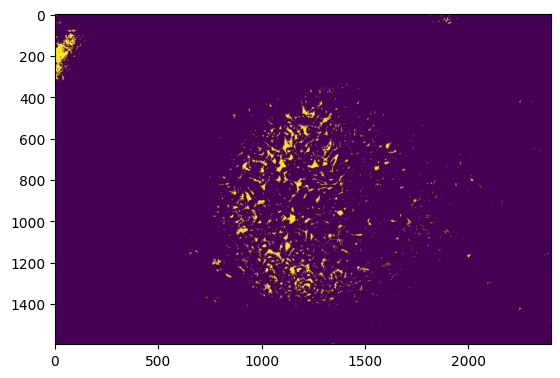

In [127]:
plt.imshow((png < backscatter)[:, :, 0])

In [128]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [129]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [130]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [131]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [132]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 4, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)

    return direction

In [133]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 4) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(100):
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

torch.Size([1598, 2402, 3])

In [134]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

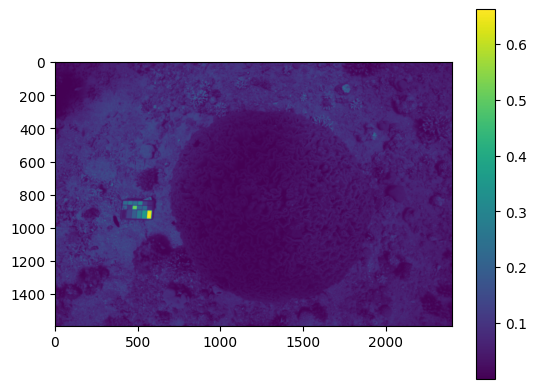

In [135]:
imshow(a_values[:, :, 0])

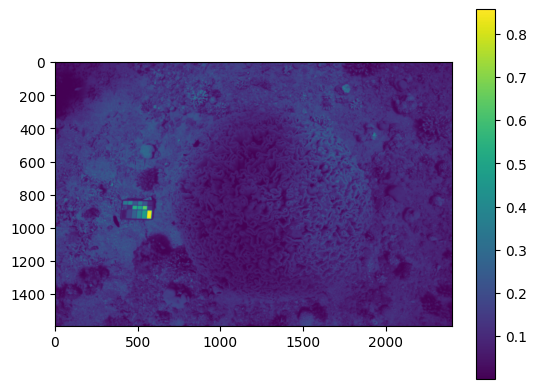

In [136]:
imshow(a_values[:, :, 1])

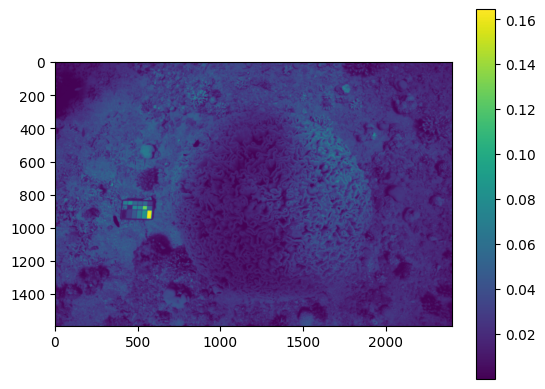

In [137]:
imshow(a_values[:, :, 2])

1.7143973


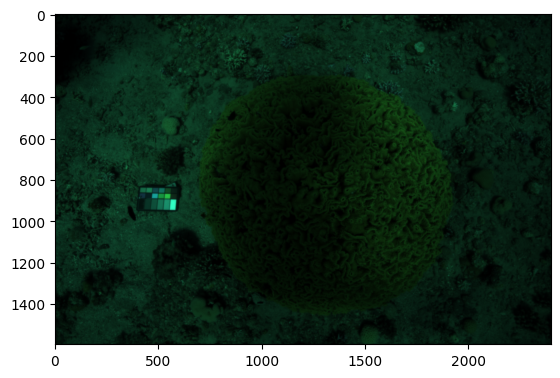

In [138]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

In [139]:
np.sort(local_illuminant_map.flatten()), (local_illuminant_map[:, :, 0] <= 0).mean()

(array([4.9898254e-09, 5.4009628e-09, 5.8522867e-09, ..., 1.7129389e+00,
        1.7137959e+00, 1.7143973e+00], shape=(11491200,), dtype=float32),
 np.float64(0.0))

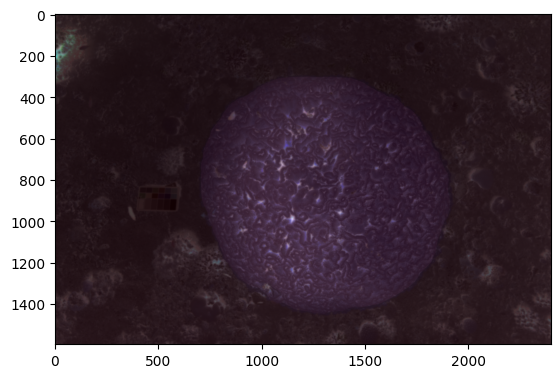

In [140]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

beta_min = beta_d_coarse.min()
beta_max = beta_d_coarse.max() - beta_min
imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")

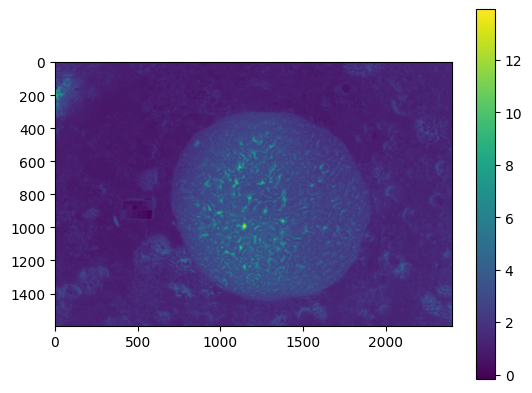

In [141]:
imshow(beta_d_coarse[:, :, 0])

In [142]:
np.sort(beta_d_coarse[:, :, 0].flatten()), np.isnan(beta_d_coarse[:,:,0].flatten()).mean(), (beta_d_coarse[:,:,0].flatten() < 0).mean()

(array([-0.16126202, -0.16121037, -0.16105531, ..., 13.908096  ,
        13.912485  , 13.932202  ], shape=(3830400,), dtype=float32),
 np.float64(0.0),
 np.float64(0.00039813074352548035))

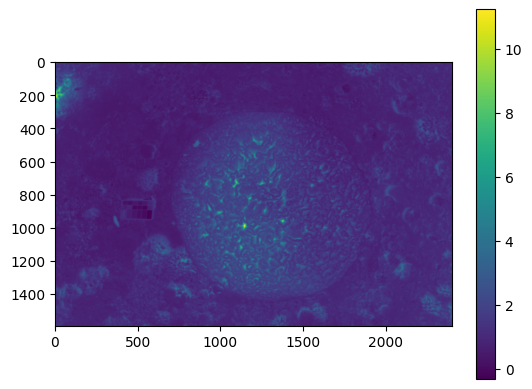

In [143]:
imshow(beta_d_coarse[:, :, 1])

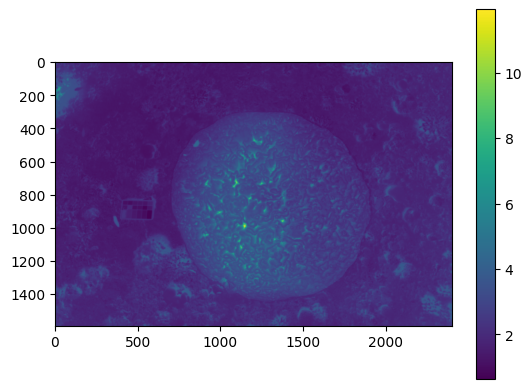

In [144]:
imshow(beta_d_coarse[:, :, 2])

### Refined Estimate of $\beta_c^D(z)$

In [145]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [146]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [147]:
def compute_beta_D_args(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int):
    a = - 0.5 * ((np.log(local_illuminant_map[:, :, color_channel]) ** 2).sum() / (depths * np.log(local_illuminant_map[:, :, color_channel])).sum() + (depths ** 2 * np.log(local_illuminant_map[:, :, color_channel] ** 3)).sum() / (depths * np.log(local_illuminant_map[:, :, color_channel]) ** 2).sum())
    c = a

    num_sum_1 = (np.log(local_illuminant_map[:, :, color_channel]) ** 2 * depths).sum()
    denom_sum_1 = (np.log(local_illuminant_map[:, :, color_channel]) * (depths ** 2)).sum()

    num_sum_2 = (depths ** 3 * np.log(local_illuminant_map[:, :, color_channel]) ** 3).sum()
    denom_sum_2 = (depths ** 2 * np.log(local_illuminant_map[:, :, color_channel]) ** 2).sum()

    b = -(num_sum_1) / (denom_sum_1 * a) + num_sum_2 / denom_sum_2
    d = -(num_sum_1) / (denom_sum_1 * c) + num_sum_2 / denom_sum_2

    params = a, b, c, d

    # lo = np.array([0, -np.inf, 0, -np.inf])
    # hi = np.array([np.inf, 0, np.inf, 0])

    # result = least_squares(optimize_compute_beta_D, params, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
    # params = result.x

    return params

In [148]:
b_args = compute_beta_D_args(local_illuminant_map, tif, 0)

b_args

# (np.float32(0.9593941),
# np.float32(-1.2186562),
# np.float32(0.9593941),
# np.float32(-1.2186562))

(np.float32(1.8142397),
 np.float32(-3.9530487),
 np.float32(1.8142397),
 np.float32(-3.9530487))

In [149]:
g_args = compute_beta_D_args(local_illuminant_map, tif, 1)

g_args

(np.float32(1.838396),
 np.float32(-4.0733805),
 np.float32(1.838396),
 np.float32(-4.0733805))

In [150]:
r_args = compute_beta_D_args(local_illuminant_map, tif, 2)

r_args

(np.float32(1.8101346),
 np.float32(-4.713581),
 np.float32(1.8101346),
 np.float32(-4.713581))

In [151]:
b_loss = np.linalg.norm(optimize_compute_beta_D(b_args, local_illuminant_map[:, :, 0], tif))
g_loss = np.linalg.norm(optimize_compute_beta_D(g_args, local_illuminant_map[:, :, 1], tif))
r_loss = np.linalg.norm(optimize_compute_beta_D(r_args, local_illuminant_map[:, :, 2], tif))

b_loss, g_loss, r_loss

(np.float32(1328485.4), np.float32(1315221.8), np.float32(8238645.0))

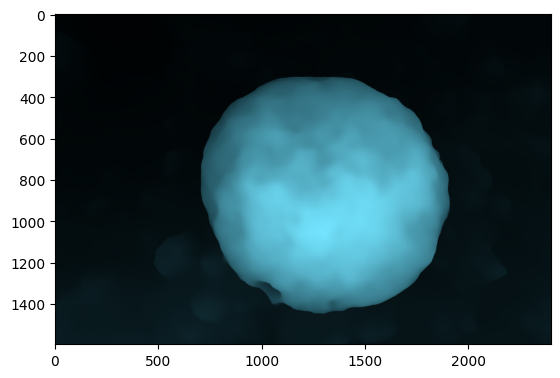

In [152]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(b_args[0], b_args[1], b_args[2], b_args[3], tif)
beta_d[:, :, 1] = compute_beta_D(g_args[0], g_args[1], g_args[2], g_args[3], tif)
beta_d[:, :, 2] = compute_beta_D(r_args[0], r_args[1], r_args[2], r_args[3], tif)

beta_d_min = beta_d.min()
beta_d_max = beta_d.max() - beta_d_min
imshow((beta_d - beta_d_min) / beta_d_max, color_channel="bgr")

1.0019075 1.0015013 1.0003856
1.0653554 1.0582943 1.02923


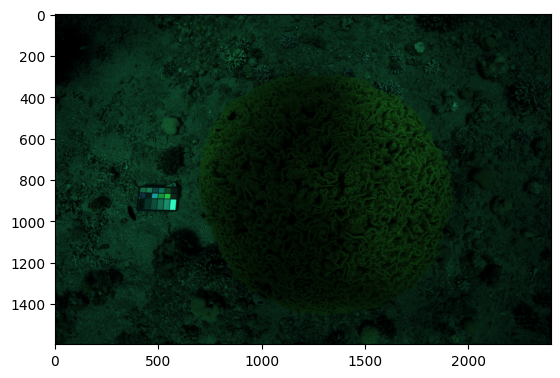

In [153]:
J = np.zeros_like(direct_signal)

print(np.exp(beta_d[:, :, 0] * tif).min(), np.exp(beta_d[:, :, 1] * tif).min(), np.exp(beta_d[:, :, 2] * tif).min())
print(np.exp(beta_d[:, :, 0] * tif).max(), np.exp(beta_d[:, :, 1] * tif).max(), np.exp(beta_d[:, :, 2] * tif).max())

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

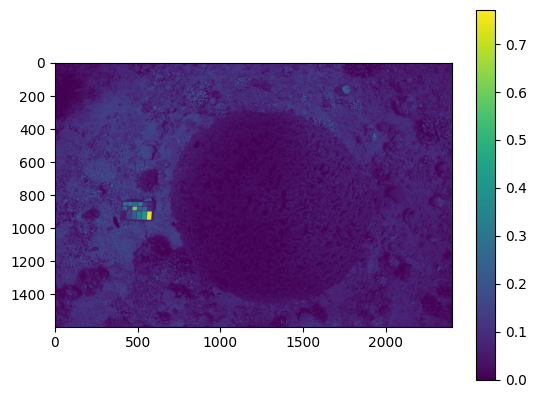

In [154]:
imshow(J[:, :, 0])

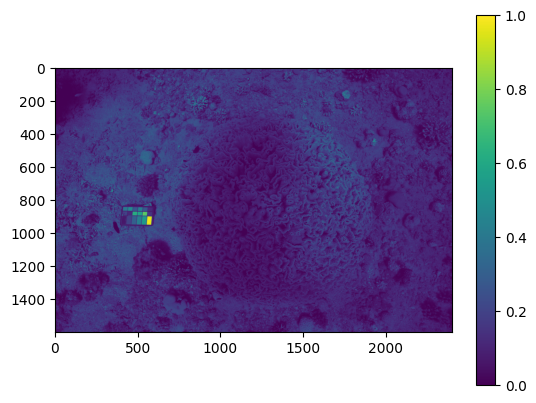

In [155]:
imshow(J[:, :, 1])

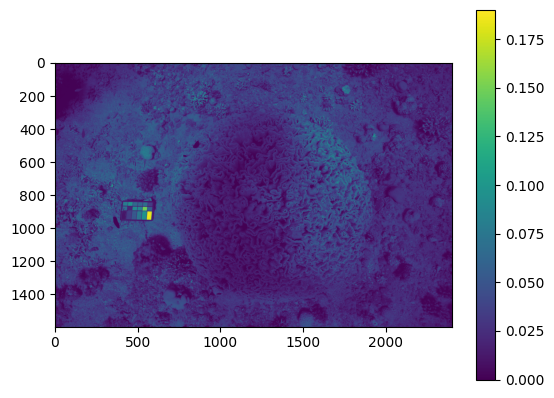

In [156]:
imshow(J[:, :, 2])

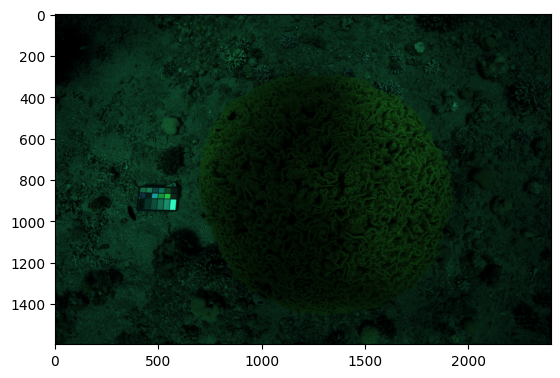

In [157]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [158]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [159]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

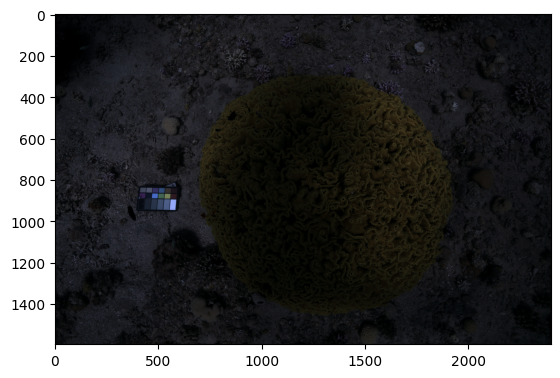

In [160]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [161]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

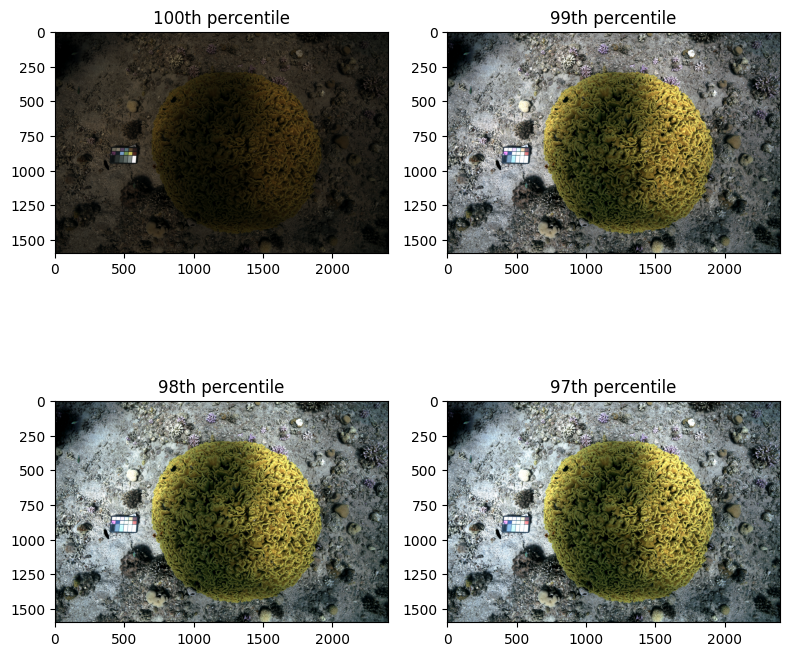

In [162]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

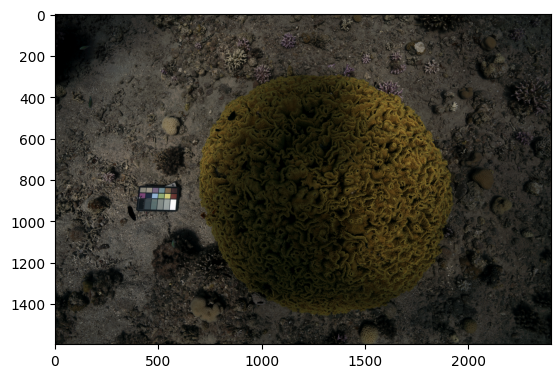

In [163]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte((0.8 * white_patch(op_wp, 100) + 0.2 * white_patch(op_wp, 99)))

imshow(img, color_channel="bgr")

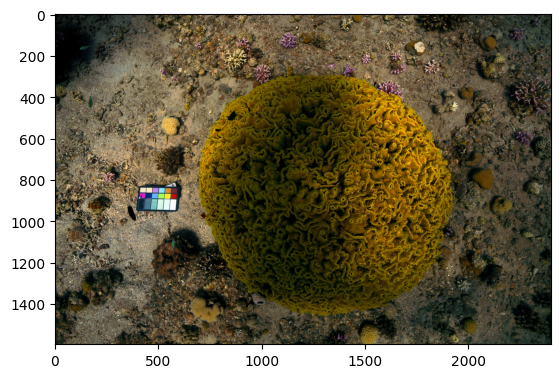

In [164]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

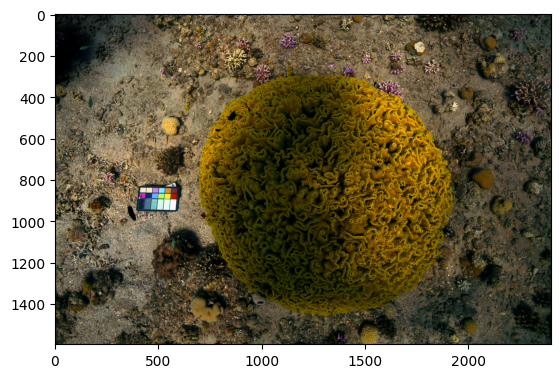

In [165]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

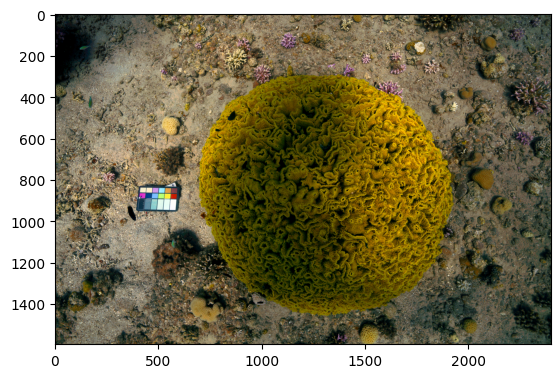

In [166]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.8)

imshow(img_gamma, color_channel="bgr")

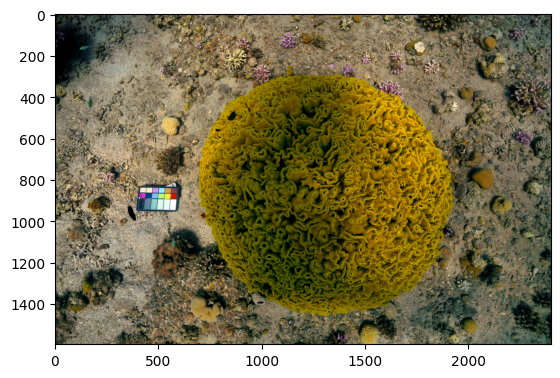

In [167]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [168]:
cv2.imwrite("output/crutchfield_perry_final.png", img_as_ubyte(img_hist))

True